In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
from tqdm import tqdm
from scipy.fft import fft2, fftshift
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
import timm
from datasets import load_dataset, concatenate_datasets

In [2]:
#--------------------------------------------------------------------------------
# Configuration
#--------------------------------------------------------------------------------

# Preprocessing configuration
PREPROCESS_CONFIG = {
    'face_alignment': False,
    'image_size': (224, 224)
}

# Model configuration
MODEL_CONFIG = {
    'spatial': {
        'backbone': 'xception',  
        'pretrained': True,
        'freeze_backbone': False,
        'output_dim': 1024
    },
    'frequency': {
        'backbone': 'custom_cnn',  # Custom CNN for frequency domain
        'input_channels': 2,  # Magnitude and phase spectrum
        'output_dim': 512
    },
    'ensemble': {
        'input_dim': 1024 + 512,  # Combined dimensions from both streams
        'hidden_dims': [512, 128],
        'dropout': 0.5
    }
}

# Training configuration
TRAIN_CONFIG = {
    'batch_size': 16, 
    'num_epochs': 5,  
    'learning_rate': 0.00005,
    'weight_decay': 0.0001,
    'lr_scheduler': 'cosine',
    'early_stopping_patience': 3, 
    'save_best_only': True
}

In [3]:
#--------------------------------------------------------------------------------
# Preprocessing Utilities
#--------------------------------------------------------------------------------

class FrequencyTransformer:
    def __init__(self):
        """Initialize frequency domain transformer"""
        pass
        
    def transform(self, image):
        """
        Transform image to frequency domain
        
        Args:
            image: Input image (numpy array)
            
        Returns:
            Tuple of (magnitude spectrum, phase spectrum)
        """
        # Convert to grayscale if color
        if len(image.shape) > 2:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
            
        # Apply FFT
        fft = fft2(gray)
        fft_shift = fftshift(fft)
        
        # Compute magnitude spectrum (logarithmic scale)
        magnitude = np.log1p(np.abs(fft_shift))
        
        # Normalize magnitude for better visualization and learning
        magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-8)
        
        # Compute phase spectrum
        phase = np.angle(fft_shift)
        phase = (phase + np.pi) / (2 * np.pi)  # Normalize to [0, 1]
        
        return magnitude, phase

In [4]:
#--------------------------------------------------------------------------------
# Dataset Loader (Hugging Face)
#--------------------------------------------------------------------------------

def get_huggingface_dataloader(batch_size=32, phase='train', num_workers=4, **kwargs):
    """
    Get dataloader for HuggingFace deepfake dataset
    
    Args:
        batch_size: Batch size
        phase: 'train', 'val', or 'test'
        num_workers: Number of workers for data loading
        **kwargs: Additional arguments
        
    Returns:
        DataLoader for the dataset
    """
    # Load dataset
    ds = load_dataset("Hemg/deepfake-and-real-images")
    
    # Determine sample sizes based on phase
    if phase == 'train':
        sample_size = 10000  
    elif phase == 'val':
        sample_size = 5000
    else:  # test
        sample_size = 5000  
    
    actual_workers = 0 if phase == 'test' else num_workers
    print(f"Data loading config - Phase: {phase}, Batch size: {batch_size}, Workers: {actual_workers}")
    
    # Efficiently split dataset
    if 'train' in ds:
        # Select samples based on phase
        if phase == 'train':
            start_idx = 0
            end_idx = sample_size * 6
        elif phase == 'val':
            start_idx = sample_size * 6
            end_idx = start_idx + sample_size * 2
        else:  # phase == 'test'
            start_idx = sample_size * 8
            end_idx = start_idx + sample_size * 2
            
        selected_subset = ds['train'].shuffle(seed=42).select(range(start_idx, end_idx))
        
        # Balance classes
        real_samples = selected_subset.filter(lambda x: x['label'] == 1)  # Real images have label 1
        fake_samples = selected_subset.filter(lambda x: x['label'] == 0)  # Fake images have label 0
        
        # Limit each class to the specified sample size
        max_samples = min(len(real_samples), len(fake_samples), sample_size)
        real_samples = real_samples.select(range(max_samples))
        fake_samples = fake_samples.select(range(max_samples))
        
        # Print dataset statistics for debugging
        if phase == 'test':
            print(f"Test dataset stats - Real: {len(real_samples)}, Fake: {len(fake_samples)}, Total: {len(real_samples) + len(fake_samples)}")
        
        dataset = concatenate_datasets([real_samples, fake_samples]).shuffle(seed=42)
    else:
        dataset = ds['train']
    
    # Initialize frequency transformer
    freq_transformer = FrequencyTransformer() if kwargs.get('use_frequency', True) else None
    
    def preprocess_image(example):
        try:
            # Get image from example
            image = example['image']
            
            # Resize if needed
            if image.size != PREPROCESS_CONFIG['image_size']:
                image = image.resize(PREPROCESS_CONFIG['image_size'])
            
            # Convert to numpy array
            image_np = np.array(image, dtype=np.uint8)
            
            # Process frequency domain if needed
            if freq_transformer is not None:
                # Convert to grayscale for frequency analysis
                gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
                magnitude, phase = freq_transformer.transform(gray)
                
                # Create frequency tensor
                freq_tensor = torch.cat([
                    torch.tensor(magnitude, dtype=torch.float).unsqueeze(0),
                    torch.tensor(phase, dtype=torch.float).unsqueeze(0)
                ], dim=0)
            
            # Normalize spatial image for training
            image_np = (image_np.astype(np.float32) / 255.0 - 0.5) / 0.5
            
            # Create result dictionary
            result = {
                'spatial': torch.tensor(image_np.transpose(2, 0, 1), dtype=torch.float),
                'label': torch.tensor(example['label'], dtype=torch.long),
            }
            
            if freq_transformer is not None:
                result['frequency'] = freq_tensor
            
            return result
        except Exception as e:
            print(f"Error processing example: {e}")
            raise e
    
    # Apply preprocessing to dataset
    try:
        print(f"Starting {phase} dataset preprocessing...")
        
        # For test phase, use non-parallel processing
        if phase == 'test':
            # Process sequentially for test data
            processed_ds = dataset.map(
                preprocess_image,
                batched=False,
                remove_columns=['image'],
                desc=f"Preprocessing {phase} dataset"
            )
        else:
            # Use parallel processing for training/validation
            processed_ds = dataset.map(
                preprocess_image,
                batched=False,
                num_proc=actual_workers,
                remove_columns=['image'],
                desc=f"Preprocessing {phase} dataset"
            )
        
        print(f"Finished preprocessing {phase} dataset")
        
        # Convert to PyTorch format
        processed_ds.set_format(type='torch', columns=['spatial', 'frequency', 'label'])
        
        return DataLoader(
            processed_ds,
            batch_size=min(batch_size, len(processed_ds)),
            shuffle=(phase == 'train'),
            num_workers=actual_workers,
            pin_memory=(phase != 'test'),
            drop_last=(phase == 'train')
        )
    except Exception as e:
        print(f"Error in dataset processing: {e}")
        raise e


In [5]:
#--------------------------------------------------------------------------------
# Model Architecture
#--------------------------------------------------------------------------------

class SpatialStream(nn.Module):
    def __init__(self, config=None):
        """
        Spatial stream for deepfake detection
        
        Args:
            config: Configuration for spatial stream
        """
        super(SpatialStream, self).__init__()
        
        if config is None:
            config = MODEL_CONFIG['spatial']
            
        self.backbone_name = config.get('backbone', 'xception')
        self.pretrained = config.get('pretrained', True)
        self.freeze_backbone = config.get('freeze_backbone', False)
        self.output_dim = config.get('output_dim', 1024)
        
        # Initialize backbone
        if self.backbone_name == 'xception':
            self.backbone = timm.create_model('xception', pretrained=self.pretrained)
            self.backbone.fc = nn.Identity()  # Remove classification head
            self.feature_dim = 2048
        elif self.backbone_name == 'resnet50':
            self.backbone = timm.create_model('resnet50', pretrained=self.pretrained)
            self.backbone.fc = nn.Identity()  # Remove classification head
            self.feature_dim = 2048
        else:
            raise ValueError(f"Unsupported backbone: {self.backbone_name}")
                            
        # Additional layers
        self.spatial_head = nn.Sequential(
            nn.Linear(self.feature_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, self.output_dim)
        )
        
        if self.freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor (batch_size, 3, H, W)
            
        Returns:
            Feature tensor (batch_size, output_dim)
        """
        features = self.backbone(x)
        return self.spatial_head(features)
    

In [6]:
class FrequencyStream(nn.Module):
    def __init__(self, config=None):
        """
        Frequency stream for deepfake detection
        
        Args:
            config: Configuration for frequency stream
        """
        super(FrequencyStream, self).__init__()
        
        if config is None:
            config = MODEL_CONFIG['frequency']
            
        self.input_channels = config.get('input_channels', 2)  # Magnitude and phase
        self.output_dim = config.get('output_dim', 512)
        
        # CNN for frequency analysis
        self.freq_cnn = nn.Sequential(
            # First conv block
            nn.Conv2d(self.input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second conv block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth conv block
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fifth conv block
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # FC layers
        self.freq_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, self.output_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor (batch_size, 2, H, W) - magnitude and phase
            
        Returns:
            Feature tensor (batch_size, output_dim)
        """
        features = self.freq_cnn(x)
        return self.freq_head(features)
    

In [7]:
class EnsembleClassifier(nn.Module):
    def __init__(self, config=None):
        """
        Ensemble classifier combining spatial and frequency features
        
        Args:
            config: Configuration for ensemble classifier
        """
        super(EnsembleClassifier, self).__init__()
        
        if config is None:
            config = MODEL_CONFIG['ensemble']
            
        self.input_dim = config.get('input_dim', 1024 + 512)
        self.hidden_dims = config.get('hidden_dims', [512, 128])
        self.dropout = config.get('dropout', 0.5)
        
        # Build classifier
        layers = []
        
        # Input layer
        layers.append(nn.Linear(self.input_dim, self.hidden_dims[0]))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Dropout(self.dropout))
        
        # Hidden layers
        for i in range(len(self.hidden_dims) - 1):
            layers.append(nn.Linear(self.hidden_dims[i], self.hidden_dims[i + 1]))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(self.dropout))
            
        # Output layer
        layers.append(nn.Linear(self.hidden_dims[-1], 1))
        
        self.classifier = nn.Sequential(*layers)
        
    def forward(self, spatial_features, freq_features):
        """
        Forward pass
        
        Args:
            spatial_features: Spatial features (batch_size, spatial_dim)
            freq_features: Frequency features (batch_size, freq_dim)
            
        Returns:
            Classification logits (batch_size, 1)
        """
        # Concatenate features
        combined = torch.cat([spatial_features, freq_features], dim=1)
        
        # Classify
        return self.classifier(combined)

In [8]:
class DeepfakeDetector(nn.Module):
    def __init__(self, spatial_config=None, freq_config=None, ensemble_config=None):
        """
        Complete deepfake detector model
        
        Args:
            spatial_config: Configuration for spatial stream
            freq_config: Configuration for frequency stream
            ensemble_config: Configuration for ensemble classifier
        """
        super(DeepfakeDetector, self).__init__()
        
        # Spatial stream
        self.spatial_stream = SpatialStream(spatial_config)
        
        # Frequency stream
        self.freq_stream = FrequencyStream(freq_config)
        
        # Ensemble classifier
        self.ensemble = EnsembleClassifier(ensemble_config)
        
    def forward(self, data_dict):
        """
        Forward pass
        
        Args:
            data_dict: Dictionary with 'spatial' and 'frequency' keys
            
        Returns:
            Classification logits (batch_size, 1)
        """
        # Extract inputs
        spatial_input = data_dict['spatial']
        freq_input = data_dict['frequency']
        
        # Process through streams
        spatial_features = self.spatial_stream(spatial_input)
        freq_features = self.freq_stream(freq_input)
        
        # Ensemble classification
        logits = self.ensemble(spatial_features, freq_features)
        
        return logits

In [9]:
#--------------------------------------------------------------------------------
# Training Functions
#--------------------------------------------------------------------------------

def train_epoch(model, dataloader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    
    running_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []
    
    # Training loop
    pbar = tqdm(dataloader, desc=f'Epoch {epoch} [Train]')
    for i, batch in enumerate(pbar):
        # Move data to device
        spatial = batch['spatial'].to(device)
        frequency = batch['frequency'].to(device)
        labels = batch['label'].to(device).float()
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model({'spatial': spatial, 'frequency': frequency})
        outputs = outputs.squeeze(1)  # Shape: (batch_size, 1) -> (batch_size)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update statistics
        running_loss += loss.item()
        
        # Calculate batch predictions
        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        labels_np = labels.detach().cpu().numpy().astype(int)
        
        all_labels.extend(labels_np)
        all_preds.extend(preds)
        all_probs.extend(probs)
        
        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss / (i + 1), 
            'acc': accuracy_score(labels_np, preds) if len(np.unique(labels_np)) > 1 else 0.0
        })
    
    # Calculate metrics
    epoch_loss = running_loss / len(dataloader)
    
    # Calculate metrics if we have valid data
    if len(all_labels) > 0 and len(np.unique(all_labels)) > 1:
        metrics = {
            'loss': epoch_loss,
            'accuracy': accuracy_score(all_labels, all_preds),
            'precision': precision_score(all_labels, all_preds, zero_division=0),
            'recall': recall_score(all_labels, all_preds, zero_division=0),
            'f1': f1_score(all_labels, all_preds, zero_division=0),
            'auc': roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.5
        }
    else:
        metrics = {
            'loss': epoch_loss,
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0,
            'auc': 0.5
        }
    
    return metrics


In [10]:
def validate(model, dataloader, criterion, device, epoch):
    """Validate the model"""
    model.eval()
    
    running_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []
    
    # No gradient calculation needed
    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f'Epoch {epoch} [Val]')
        for i, batch in enumerate(pbar):
            # Move data to device
            spatial = batch['spatial'].to(device)
            frequency = batch['frequency'].to(device)
            labels = batch['label'].to(device).float()
            
            # Forward pass
            outputs = model({'spatial': spatial, 'frequency': frequency})
            outputs = outputs.squeeze(1)  # Shape: (batch_size, 1) -> (batch_size)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Update statistics
            running_loss += loss.item()
            
            # Calculate batch predictions
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            labels_np = labels.cpu().numpy().astype(int)
            
            all_labels.extend(labels_np)
            all_preds.extend(preds)
            all_probs.extend(probs)
            
            # Update progress bar
            pbar.set_postfix({
                'loss': running_loss / (i + 1), 
                'acc': accuracy_score(labels_np, preds) if len(np.unique(labels_np)) > 1 else 0.0
            })
    
    # Calculate metrics
    epoch_loss = running_loss / max(len(dataloader), 1)  # Prevent division by zero
    
    if len(all_labels) > 0 and len(np.unique(all_labels)) > 1:
        metrics = {
            'loss': epoch_loss,
            'accuracy': accuracy_score(all_labels, all_preds),
            'precision': precision_score(all_labels, all_preds, zero_division=0),
            'recall': recall_score(all_labels, all_preds, zero_division=0),
            'f1': f1_score(all_labels, all_preds, zero_division=0),
            'auc': roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.5
        }
    else:
        metrics = {
            'loss': epoch_loss,
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0,
            'auc': 0.5
        }
    
    return metrics


In [11]:
#--------------------------------------------------------------------------------
# Visualization Functions
#--------------------------------------------------------------------------------

def compute_confusion_matrix(model, dataloader, device):
    """
    Compute confusion matrix for model evaluation
    
    Args:
        model: Model to evaluate
        dataloader: DataLoader with test data
        device: Device to run evaluation on
        
    Returns:
        confusion_matrix: 2x2 confusion matrix
        all_labels: True labels
        all_preds: Predicted labels
        all_probs: Prediction probabilities
    """
    model.eval()
    
    all_labels = []
    all_preds = []
    all_probs = []
    
    total_batches = len(dataloader)
    print(f"Processing {total_batches} batches")
    
    # No gradient calculation needed
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            try:
                # Print progress every few batches
                if batch_idx % max(1, total_batches // 10) == 0:
                    print(f"Processing batch {batch_idx+1}/{total_batches}")
                
                # Move data to device
                spatial = batch['spatial'].to(device)
                frequency = batch['frequency'].to(device)
                labels = batch['label'].to(device)
                
                # Forward pass
                outputs = model({'spatial': spatial, 'frequency': frequency})
                
                # Calculate batch predictions
                probs = torch.sigmoid(outputs).cpu().numpy().flatten()
                preds = (probs >= 0.5).astype(int)
                labels_np = labels.cpu().numpy()
                
                all_labels.extend(labels_np)
                all_preds.extend(preds)
                all_probs.extend(probs)
                
            except Exception as e:
                print(f"Error processing batch {batch_idx}: {e}")
                continue
    
    print(f"Processed {len(all_labels)} total samples")
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return cm, all_labels, all_preds, all_probs


In [12]:
def evaluate_on_test_data(model, batch_size=32, device=None, output_dir='./outputs'):
    """
    Evaluate model on real test data
    
    Args:
        model: Trained model to evaluate
        batch_size: Batch size for evaluation
        device: Device to run evaluation on
        output_dir: Directory to save evaluation results
        
    Returns:
        Dictionary with evaluation metrics
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print("Loading test data...")
    test_batch_size = 2  
    test_loader = get_huggingface_dataloader(
        batch_size=test_batch_size, 
        phase='test'
    )
    
    # Compute confusion matrix and predictions
    print("Computing test metrics...")
    cm, all_labels, all_preds, all_probs = compute_confusion_matrix(model, test_loader, device)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.5,
        'confusion_matrix': cm.tolist(),
    }
    
    # Print metrics
    print("\nTest Metrics:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1 Score:  {metrics['f1']:.4f}")
    print(f"  AUC:       {metrics['auc']:.4f}")
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    print("  [TN, FP]")
    print("  [FN, TP]")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Test Data Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'plots', 'test_confusion_matrix.png'), dpi=300)
    plt.show()
    plt.close()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {metrics["auc"]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'plots', 'test_roc_curve.png'), dpi=300)
    plt.show()
    plt.close()
    
    # Save test metrics
    with open(os.path.join(output_dir, 'test_metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=4)
    
    return metrics


In [13]:
def plot_training_results(train_history, val_history, output_dir):
    """
    Plot training results using Matplotlib
    
    Args:
        train_history: Dictionary of training metrics by epoch
        val_history: Dictionary of validation metrics by epoch
        output_dir: Directory to save plots
    """
    plots_dir = os.path.join(output_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Extract epochs
    epochs = list(range(1, len(train_history['loss']) + 1))
    
    # Metrics to plot
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc']
    
    # Plot each metric
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_history[metric], marker='o', linestyle='-', label=f'Train {metric}')
        plt.plot(epochs, val_history[metric], marker='s', linestyle='--', label=f'Validation {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, f'{metric}_plot.png'), dpi=300)
        plt.show()
        plt.close()
    
    # Plot combined metrics
    plt.figure(figsize=(12, 8))
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        plt.plot(epochs, val_history[metric], marker='o', linestyle='-', label=f'Val {metric}')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Metrics')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'combined_metrics.png'), dpi=300)
    plt.show()
    plt.close()
    
    # Plot confusion matrix 
    if 'confusion_matrix' in val_history:
        plt.figure(figsize=(8, 6))
        cm = val_history['confusion_matrix'][-1]  
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Final Epoch)')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'confusion_matrix.png'), dpi=300)
        plt.show()
        plt.close()
    
    print(f"Training plots saved to {plots_dir}")
    return

In [14]:
def train_model(num_epochs=TRAIN_CONFIG['num_epochs'], 
                batch_size=TRAIN_CONFIG['batch_size'],
                learning_rate=TRAIN_CONFIG['learning_rate'],
                weight_decay=TRAIN_CONFIG['weight_decay'],
                patience=TRAIN_CONFIG['early_stopping_patience'],
                output_dir='./outputs',
                device=None):
    """Train the model"""
    # Set device
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Create subdirectory for plots
    plots_dir = os.path.join(output_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Create dataloaders
    train_loader = get_huggingface_dataloader(
        batch_size=batch_size, 
        phase='train',
        num_workers=2
    )
    
    val_loader = get_huggingface_dataloader(
        batch_size=batch_size, 
        phase='val',
        num_workers=2
    )
    
    # Initialize model
    model = DeepfakeDetector()
    model.to(device)
    
    # Loss function
    class_weights = torch.tensor([2.0, 1.0]).to(device)  
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    
    # Optimizer
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=weight_decay,
        betas=(0.9, 0.999),
        eps=1e-8
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=num_epochs,
        eta_min=learning_rate * 0.1
    )
    
    # Training loop
    best_val_loss = float('inf')
    best_val_metrics = None
    patience_counter = 0
    
    # Initialize history for plotting
    train_history = {metric: [] for metric in ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc']}
    val_history = {metric: [] for metric in ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc']}
    
    # Save training config
    config = {
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'weight_decay': weight_decay,
        'num_epochs': num_epochs,
        'model_config': MODEL_CONFIG,
        'device': str(device),
        'seed': 42
    }
    
    with open(os.path.join(output_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=4)
    
    for epoch in range(1, num_epochs + 1):
        # Training phase
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['accuracy']:.4f}")
        
        # Validation phase
        val_metrics = validate(model, val_loader, criterion, device, epoch)
        print(f"Epoch {epoch}/{num_epochs} - Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.4f}")
        
        # Update learning rate
        scheduler.step()
        
        # Update history for plotting
        for metric in train_history:
            train_history[metric].append(train_metrics[metric])
            val_history[metric].append(val_metrics[metric])
        
        # Save best model
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            best_val_metrics = val_metrics
            patience_counter = 0
            
            # Save model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'metrics': val_metrics
            }, os.path.join(output_dir, 'best_model.pth'))
        else:
            patience_counter += 1
            
        # Save latest model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': val_metrics
        }, os.path.join(output_dir, 'latest_model.pth'))
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping after {patience_counter} epochs without improvement")
            break
    
    # Plot training results
    plot_training_results(train_history, val_history, output_dir)
    
    # Save final metrics
    final_metrics = {
        'train': train_metrics,
        'val': val_metrics,
        'best_val': best_val_metrics
    }
    
    with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
        json.dump(final_metrics, f, indent=4)
    
    return model, best_val_metrics


Using device: cuda
Starting training...


README.md:   0%|          | 0.00/394 [00:00<?, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/366M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/356M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/347M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/348M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/190335 [00:00<?, ? examples/s]

Data loading config - Phase: train, Batch size: 16, Workers: 2


Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

Starting train dataset preprocessing...


Preprocessing train dataset (num_proc=2):   0%|          | 0/20000 [00:00<?, ? examples/s]

Finished preprocessing train dataset
Data loading config - Phase: val, Batch size: 16, Workers: 2


Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Starting val dataset preprocessing...


Preprocessing val dataset (num_proc=2):   0%|          | 0/9986 [00:00<?, ? examples/s]

Finished preprocessing val dataset


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
Epoch 1 [Train]: 100%|██████████| 1250/1250 [06:52<00:00,  3.03it/s, loss=0.21, acc=1]     


Epoch 1/5 - Train Loss: 0.2096, Acc: 0.9103


Epoch 1 [Val]: 100%|██████████| 625/625 [02:40<00:00,  3.90it/s, loss=0.0783, acc=0]    


Epoch 1/5 - Val Loss: 0.0783, Acc: 0.9709


Epoch 2 [Train]: 100%|██████████| 1250/1250 [06:52<00:00,  3.03it/s, loss=0.0488, acc=0.938]


Epoch 2/5 - Train Loss: 0.0488, Acc: 0.9829


Epoch 2 [Val]: 100%|██████████| 625/625 [02:51<00:00,  3.64it/s, loss=0.0663, acc=0]    


Epoch 2/5 - Val Loss: 0.0663, Acc: 0.9765


Epoch 3 [Train]: 100%|██████████| 1250/1250 [06:48<00:00,  3.06it/s, loss=0.0214, acc=1]    


Epoch 3/5 - Train Loss: 0.0214, Acc: 0.9931


Epoch 3 [Val]: 100%|██████████| 625/625 [02:52<00:00,  3.63it/s, loss=0.093, acc=0]     


Epoch 3/5 - Val Loss: 0.0930, Acc: 0.9761


Epoch 4 [Train]: 100%|██████████| 1250/1250 [06:49<00:00,  3.05it/s, loss=0.00692, acc=1]    


Epoch 4/5 - Train Loss: 0.0069, Acc: 0.9980


Epoch 4 [Val]: 100%|██████████| 625/625 [02:51<00:00,  3.65it/s, loss=0.115, acc=0]    


Epoch 4/5 - Val Loss: 0.1151, Acc: 0.9728


Epoch 5 [Train]: 100%|██████████| 1250/1250 [06:47<00:00,  3.07it/s, loss=0.0039, acc=1]     


Epoch 5/5 - Train Loss: 0.0039, Acc: 0.9991


Epoch 5 [Val]: 100%|██████████| 625/625 [02:53<00:00,  3.61it/s, loss=0.107, acc=0]    


Epoch 5/5 - Val Loss: 0.1069, Acc: 0.9784
Early stopping after 3 epochs without improvement


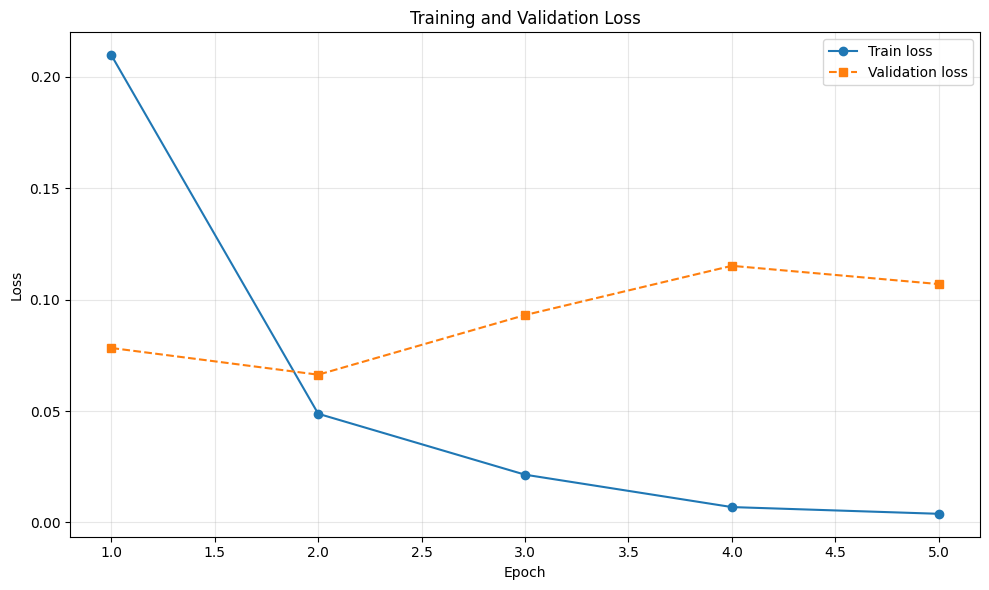

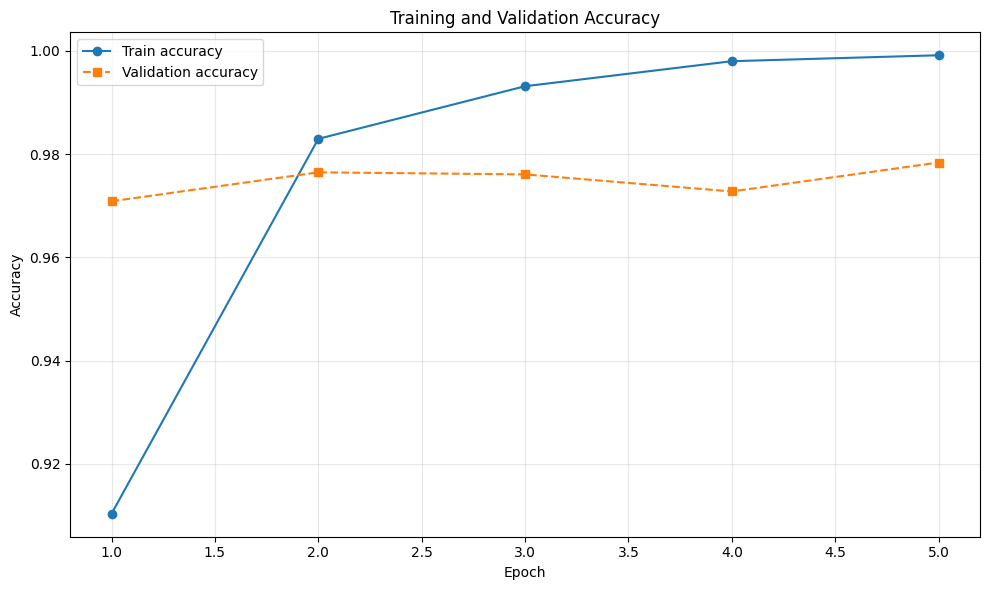

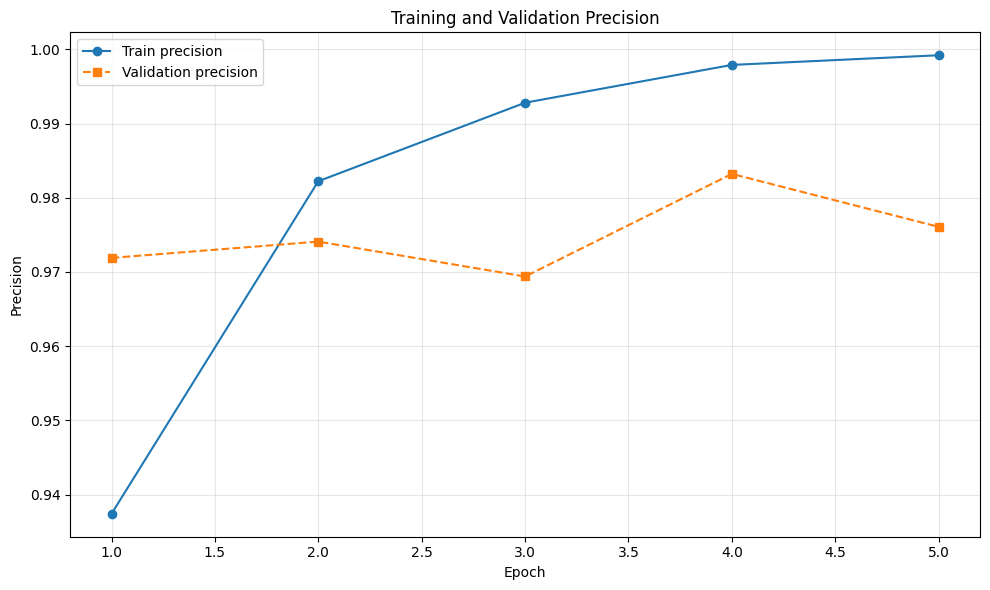

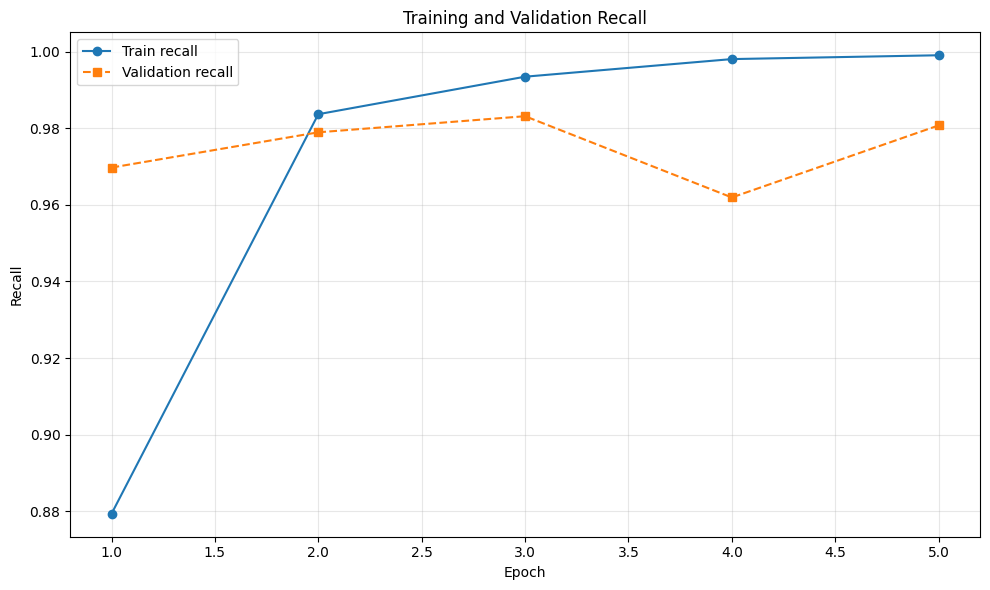

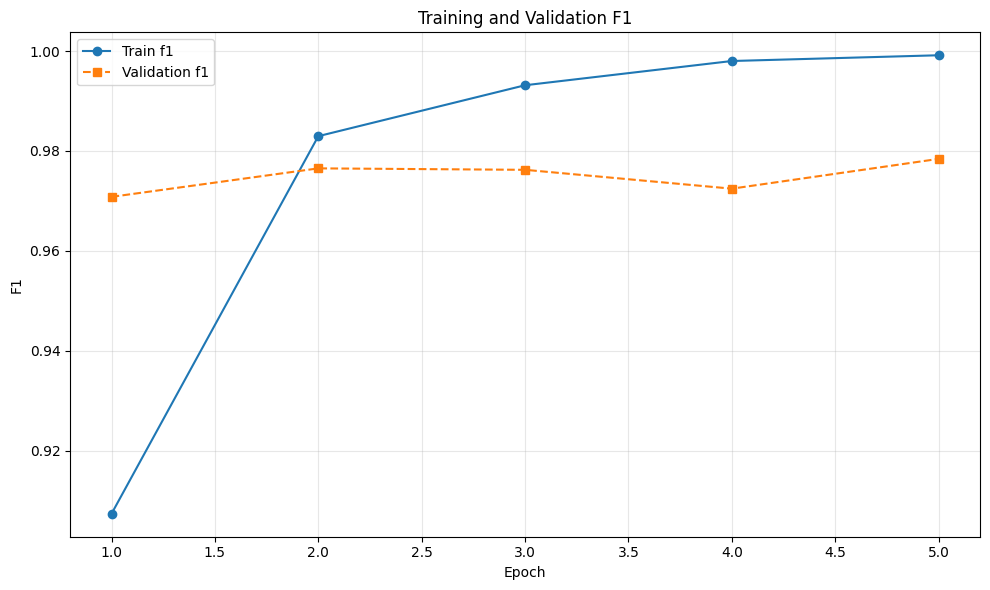

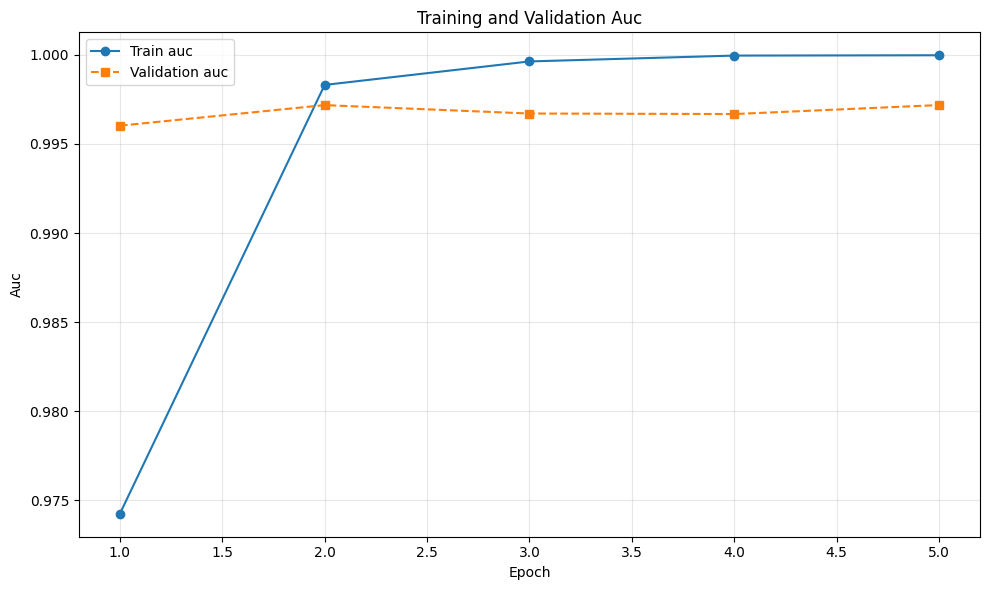

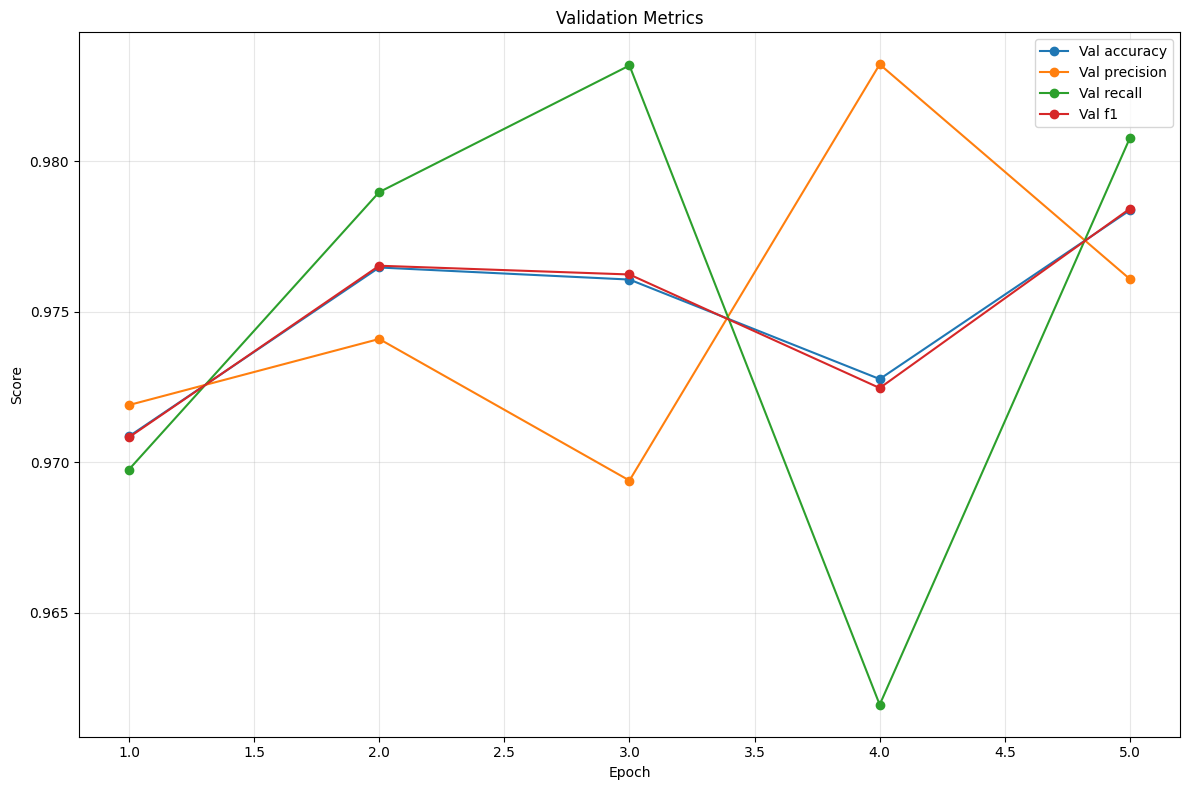

Training plots saved to /kaggle/working/outputs/plots
Final model state saved to /kaggle/working/outputs/final_model.pth

STARTING TEST EVALUATION
Loading test data...
Data loading config - Phase: test, Batch size: 2, Workers: 0


Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Test dataset stats - Real: 5000, Fake: 5000, Total: 10000
Starting test dataset preprocessing...


Preprocessing test dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Finished preprocessing test dataset
Computing test metrics...
Processing 5000 batches
Processing batch 1/5000
Processing batch 501/5000
Processing batch 1001/5000
Processing batch 1501/5000
Processing batch 2001/5000
Processing batch 2501/5000
Processing batch 3001/5000
Processing batch 3501/5000
Processing batch 4001/5000
Processing batch 4501/5000
Processed 10000 total samples

Test Metrics:
  Accuracy:  0.9768
  Precision: 0.9740
  Recall:    0.9798
  F1 Score:  0.9769
  AUC:       0.9978

Confusion Matrix:
  [TN, FP]
  [FN, TP]
[[4869  131]
 [ 101 4899]]


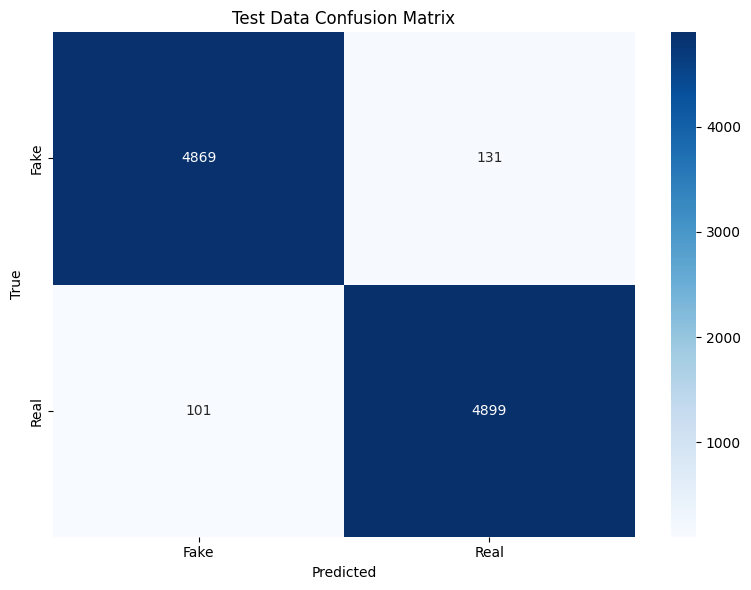

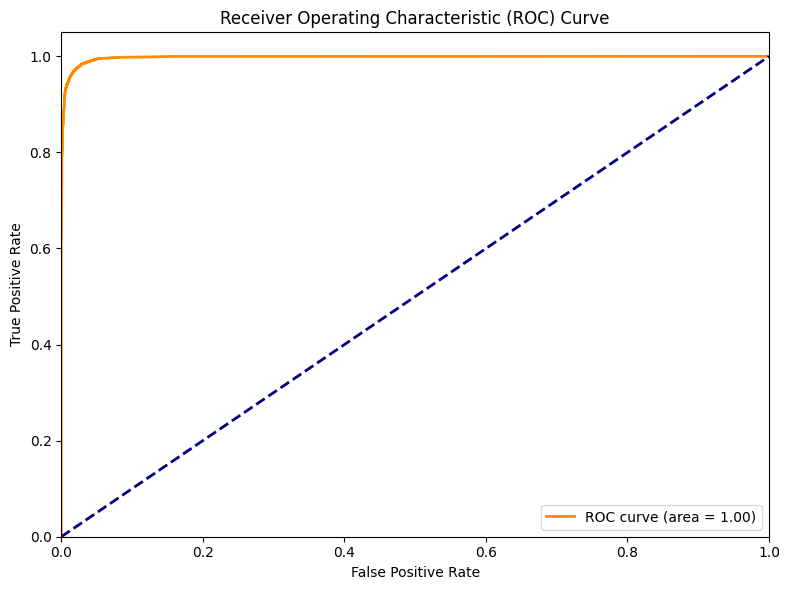


Training and evaluation completed successfully!


In [15]:
#--------------------------------------------------------------------------------
# Main Function
#--------------------------------------------------------------------------------

def main():
    """Main function to run the code in a notebook environment"""
    # --- Configuration for Notebook ---
    mode = 'train' # Set mode directly to 'train'
    output_dir = '/kaggle/working/outputs'
    # Training parameters will be taken from TRAIN_CONFIG
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    print("Starting training...")
    # Train model using parameters from TRAIN_CONFIG
    model, best_metrics = train_model(
        num_epochs=TRAIN_CONFIG['num_epochs'],
        batch_size=TRAIN_CONFIG['batch_size'],
        learning_rate=TRAIN_CONFIG['learning_rate'],
        weight_decay=TRAIN_CONFIG['weight_decay'],
        patience=TRAIN_CONFIG['early_stopping_patience'],
        output_dir=output_dir,
        device=device
    )

    # --- Explicitly save the final model state ---
    final_model_path = os.path.join(output_dir, 'final_model.pth')
    torch.save({
        'epoch': 'final', # Indicate this is the final state after training loop
        'model_state_dict': model.state_dict(),
        'metrics': best_metrics # Include best validation metrics for reference
    }, final_model_path)
    print(f"Final model state saved to {final_model_path}")
    
    # --- Evaluate on real test data ---
    print("\n" + "="*50)
    print("STARTING TEST EVALUATION")
    print("="*50)
    test_metrics = evaluate_on_test_data(
        model=model,
        batch_size=TRAIN_CONFIG['batch_size'],
        device=device,
        output_dir=output_dir
    )
    
    print("\nTraining and evaluation completed successfully!")


#--------------------------------------------------------------------------------
# Entry Point
#--------------------------------------------------------------------------------

if __name__ == "__main__":
    main()